In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner.tuners import RandomSearch, Hyperband
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras_tuner as kt

In [2]:
# Correct the paths
train_dir = r'C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\train'
test_dir = r'C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\test'

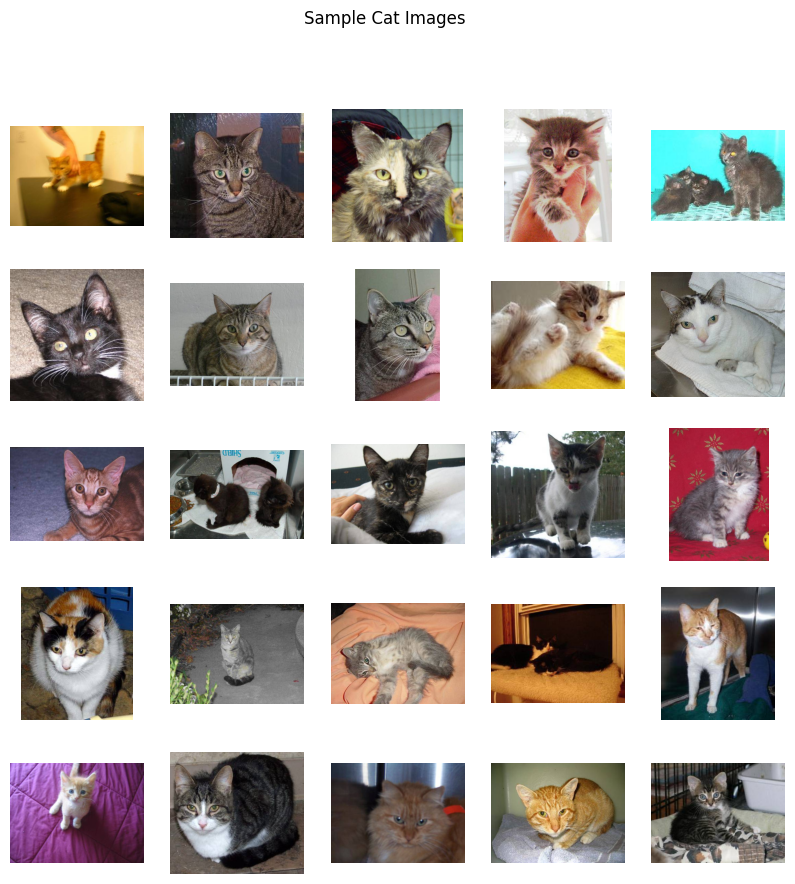

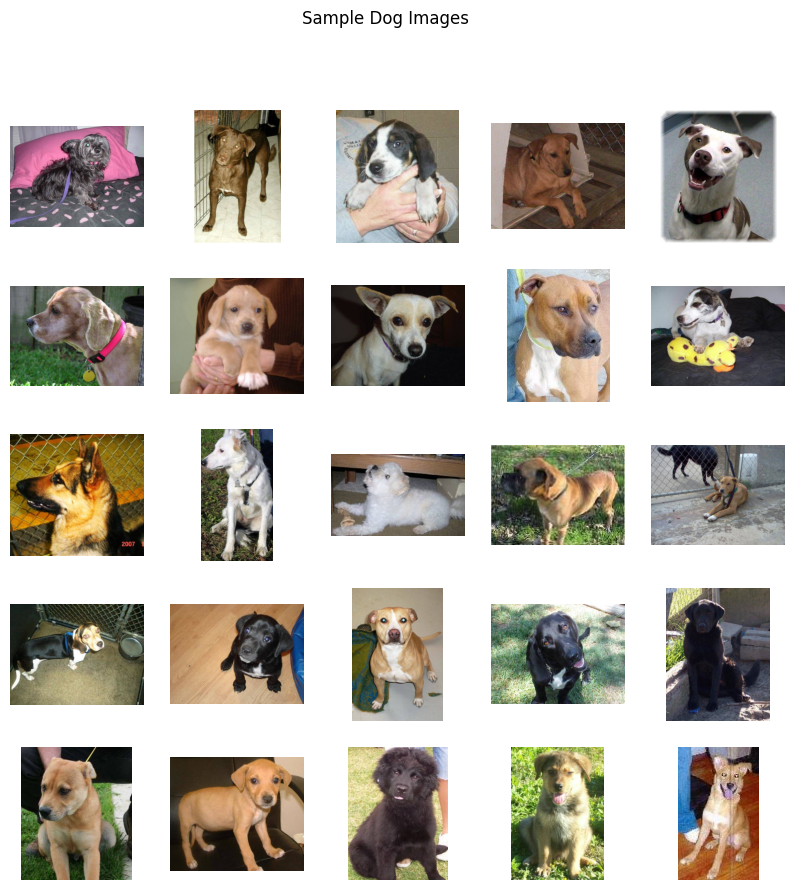

In [3]:
# Get a list of image files and separate cats and dogs based on filenames
all_images = [os.path.join(train_dir, img) for img in os.listdir(train_dir) if img.endswith('.jpg')]
cat_images = [img for img in all_images if 'cat' in os.path.basename(img)]
dog_images = [img for img in all_images if 'dog' in os.path.basename(img)]

# Display a sample of the images
def display_images(images, title):
    plt.figure(figsize=(10, 10))
    for i, img_path in enumerate(images[:25]):
        plt.subplot(5, 5, i + 1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

display_images(cat_images, "Sample Cat Images")
display_images(dog_images, "Sample Dog Images")

In [4]:
# Function to preprocess images: resize to 350x350 and normalize
def preprocess_image(img_path, img_width=350, img_height=350):
    img = Image.open(img_path).convert('RGB')  # Ensure all images are RGB
    img = img.resize((img_width, img_height))
    img_array = np.array(img) / 255.0
    return img_array

Original shape: (1002, 350, 350, 3)
Flattened shape: (1002, 367500)
PCA reduced shape: (1002, 50)


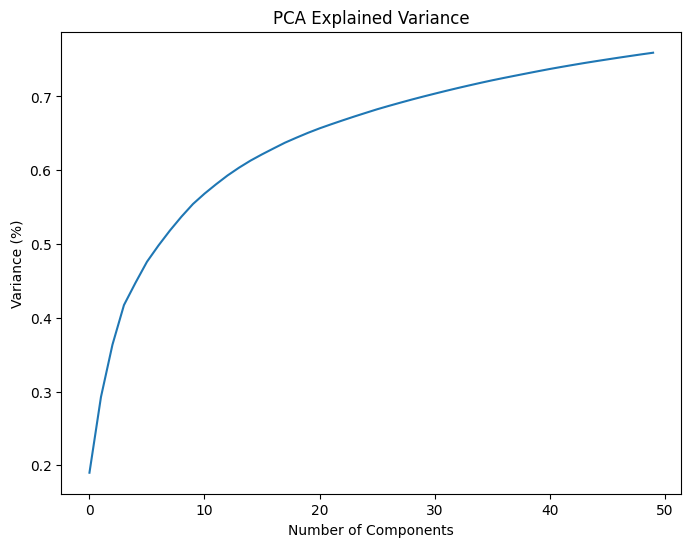

In [5]:
cat_images_preprocessed = np.array([preprocess_image(img_path) for img_path in cat_images])
dog_images_preprocessed = np.array([preprocess_image(img_path) for img_path in dog_images])

# Combine data
X = np.concatenate((cat_images_preprocessed, dog_images_preprocessed), axis=0)
y = np.concatenate((np.zeros(len(cat_images_preprocessed)), np.ones(len(dog_images_preprocessed))), axis=0)

# Flatten the images for PCA
n_samples, img_width, img_height, n_channels = X.shape
X_flattened = X.reshape(n_samples, -1)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X_flattened)

# Display shapes
print(f"Original shape: {X.shape}")
print(f"Flattened shape: {X_flattened.shape}")
print(f"PCA reduced shape: {X_pca.shape}")

# Function to visualize PCA explained variance
def plot_pca_variance(pca):
    plt.figure(figsize=(8, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)')  # for each component
    plt.title('PCA Explained Variance')
    plt.show()

plot_pca_variance(pca)

In [7]:
# Split the data into training and test sets
Xpca_train, Xpca_test, ypca_train, ypca_test = train_test_split(X_pca, y, test_size=0.2, random_state=672)

In [8]:
# Train an SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(Xpca_train, ypca_train)

# Predict on the test set
ypca_pred = svm_classifier.predict(Xpca_test)

# Evaluate the classifier
accuracy = accuracy_score(ypca_test, ypca_pred)
report = classification_report(ypca_test, ypca_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.5174129353233831
Classification Report:
              precision    recall  f1-score   support

         0.0       0.47      0.59      0.52        90
         1.0       0.58      0.46      0.51       111

    accuracy                           0.52       201
   macro avg       0.52      0.52      0.52       201
weighted avg       0.53      0.52      0.52       201



In [9]:
# Split the data into training and test sets
X_trainR, X_testR, y_trainR, y_testR = train_test_split(X_flattened, y, test_size=0.2, random_state=672)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_trainR, y_trainR)

# Predict on the test set
y_predR = rf_classifier.predict(X_testR)

# Evaluate the classifier
accuracy = accuracy_score(y_testR, y_predR)
report = classification_report(y_testR, y_predR)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.6069651741293532
Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.70      0.61        90
         1.0       0.69      0.53      0.60       111

    accuracy                           0.61       201
   macro avg       0.62      0.62      0.61       201
weighted avg       0.62      0.61      0.61       201



In [10]:
# Evaluate the model on the validation set
val_predictions = rf_classifier.predict(X_testR)
val_accuracy = accuracy_score(y_testR, val_predictions)
print(f"Validation accuracy: {val_accuracy}")

# Load and preprocess unseen images
unseen_images = [os.path.join(test_dir, img) for img in os.listdir(test_dir) if img.endswith('.jpg') or img.endswith('.png')]
unseen_images_preprocessed = np.array([preprocess_image(img_path) for img_path in unseen_images])

# Flatten the unseen images for prediction
n_samples_unseen = unseen_images_preprocessed.shape[0]
unseen_images_flattened = unseen_images_preprocessed.reshape(n_samples_unseen, -1)

# Predict labels for unseen images
unseen_predictions = rf_classifier.predict(unseen_images_flattened)

# Print predictions for unseen images
for img_path, prediction in zip(unseen_images, unseen_predictions):
    label = 'dog' if prediction == 1 else 'cat'
    print(f"Image: {img_path} - Predicted label: {label}")

Validation accuracy: 0.6069651741293532
Image: C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\test\1.jpg - Predicted label: cat
Image: C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\test\10.jpg - Predicted label: cat
Image: C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\test\100.jpg - Predicted label: cat
Image: C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\test\11.jpg - Predicted label: cat
Image: C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\test\12.jpg - Predicted label: dog
Image: C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\test\13.jpg - Predicted label: cat
Image: C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\test\14.jpg - Predicted label: cat
Image: C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\test\15.jpg - Predicted label: dog
Image: C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\test\16.jpg - Predicted label: cat
Image: C:\Users

In [13]:
# Define the parameter distribution
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=5)],  # Reduced range
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 50, num=5)] + [None],  # Reduced range
    'min_samples_split': [2, 5],  # Reduced options
    'min_samples_leaf': [1, 2],  # Reduced options
    'bootstrap': [True, False]
}

# Create a RandomForestClassifier
rf = RandomForestClassifier(random_state=672)

# Create a RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20,  # Reduced iterations
                                   cv=3, verbose=2, random_state=672, n_jobs=2)  # Use 2 cores to prevent overloading

# Fit the RandomizedSearchCV
random_search.fit(X_trainR, y_trainR)

# Get the best parameters and the best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print(f"Best parameters: {best_params}")

# Evaluate the best model
y_predR = best_model.predict(X_testR)
accuracy = accuracy_score(y_testR, y_predR)
report = classification_report(y_testR, y_predR)

# Print the evaluation metrics
print(f"Test accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\rhyth\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
27 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rhyth\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rhyth\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\rhyth\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py

Best parameters: {'n_estimators': 550, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Test accuracy: 56.22%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.51      0.58      0.54        90
         1.0       0.62      0.55      0.58       111

    accuracy                           0.56       201
   macro avg       0.56      0.56      0.56       201
weighted avg       0.57      0.56      0.56       201



In [19]:
# Evaluate the model on the validation set
val_predictions = rf_classifier.predict(X_testR)
val_accuracy = accuracy_score(y_testR, val_predictions)
print(f"Validation accuracy: {val_accuracy}")

# Load and preprocess unseen images
unseen_images = [os.path.join(test_dir, img) for img in os.listdir(test_dir) if img.endswith('.jpg') or img.endswith('.png')]
unseen_images_preprocessed = np.array([preprocess_image(img_path) for img_path in unseen_images])

# Flatten the unseen images for prediction
n_samples_unseen = unseen_images_preprocessed.shape[0]
unseen_images_flattened = unseen_images_preprocessed.reshape(n_samples_unseen, -1)

# Predict labels for unseen images
unseen_predictions = rf_classifier.predict(unseen_images_flattened)

# Function to display images with predictions
def display_predictions(images, predictions, img_paths, title):
    plt.figure(figsize=(12, 12))
    for i, (img_array, prediction, img_path) in enumerate(zip(images[:25], predictions[:25], img_paths[:25])):
        plt.subplot(5, 5, i + 1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title('Dog' if prediction == 1 else 'Cat')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display unseen images with their predictions
display_predictions(unseen_images_preprocessed, unseen_predictions, unseen_images, "Predictions on Unseen Images")

NameError: name 'rf_classifier' is not defined

In [6]:
# Ensure X has 4 dimensions
X = X.reshape(-1, img_width, img_height, 3)
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=672)


In [7]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

c:\Users\rhyth\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 348, 348, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 174, 174, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 172, 172, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 86, 86, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 84, 84, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 225792)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   115,606,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,699,777 (441.36 MB)

 Trainable params: 115,699,777 (441.36 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [12]:
batch_size=32
# Fit the model using data augmentation
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10


c:\Users\rhyth\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.4796 - loss: 2.8697 - val_accuracy: 0.4776 - val_loss: 0.6933
Epoch 2/10
 1/25 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.4375 - loss: 0.6931

c:\Users\rhyth\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.4375 - loss: 0.6931 - val_accuracy: 0.4627 - val_loss: 0.6934
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5468 - loss: 0.6943 - val_accuracy: 0.4577 - val_loss: 0.6932
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.5312 - loss: 0.6912 - val_accuracy: 0.5075 - val_loss: 0.6923
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5469 - loss: 0.6914 - val_accuracy: 0.5721 - val_loss: 0.6822
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.5000 - loss: 0.6937 - val_accuracy: 0.5821 - val_loss: 0.6830
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5317 - loss: 0.6956 - val_accuracy: 0.5522 - val_loss: 0.6803
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.4375 - loss: 0.7406 - val_accuracy: 0.6219 - val_loss: 0.6754
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5528 - loss: 0.6910 - val_accuracy: 0.6517 - val_loss: 0.6697

In [13]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

# Generate classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.5818 - loss: 0.6761
Test accuracy: 0.5771144032478333
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step
              precision    recall  f1-score   support

         0.0       0.52      0.74      0.61        90
         1.0       0.68      0.44      0.54       111

    accuracy                           0.58       201
   macro avg       0.60      0.59      0.57       201
weighted avg       0.61      0.58      0.57       201



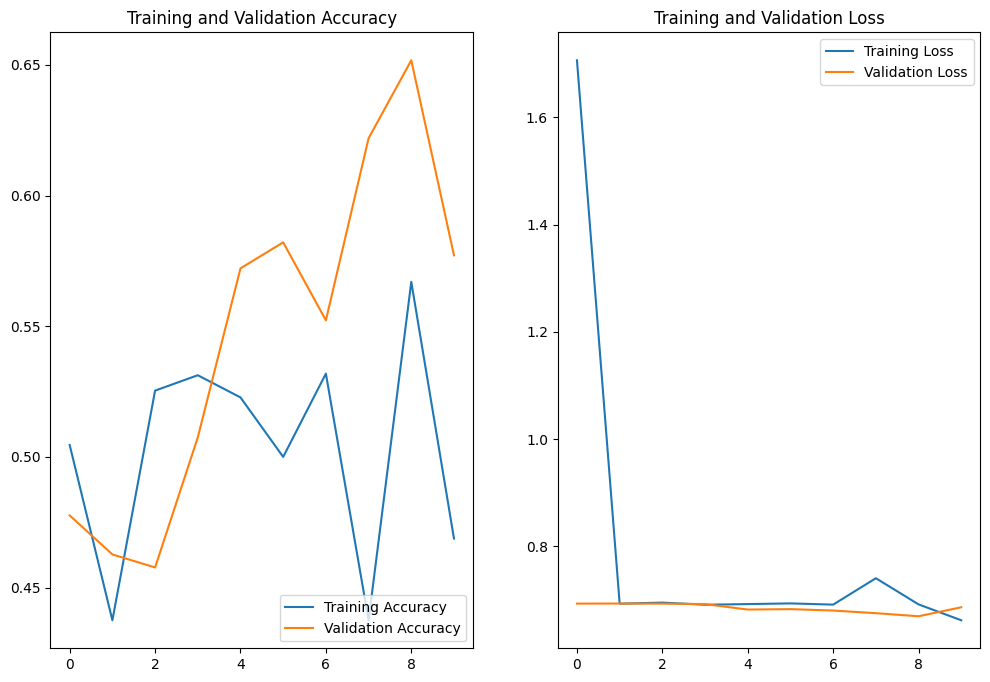

In [14]:
# Plot training & validation accuracy and loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

In [15]:
# Load and preprocess unseen images
unseen_images = [os.path.join(test_dir, img) for img in os.listdir(test_dir) if img.endswith('.jpg') or img.endswith('.png')]
unseen_images_preprocessed = np.array([preprocess_image(img_path) for img_path in unseen_images])

# Predict labels for unseen images
unseen_predictions = (model.predict(unseen_images_preprocessed) > 0.5).astype("int32")

# Print predictions for unseen images
for img_path, prediction in zip(unseen_images, unseen_predictions):
    label = 'dog' if prediction == 1 else 'cat'
    print(f"Image: {img_path} - Predicted label: {label}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
Image: C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\test\1.jpg - Predicted label: cat
Image: C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\test\10.jpg - Predicted label: cat
Image: C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\test\100.jpg - Predicted label: dog
Image: C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\test\11.jpg - Predicted label: cat
Image: C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\test\12.jpg - Predicted label: cat
Image: C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\test\13.jpg - Predicted label: cat
Image: C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\test\14.jpg - Predicted label: cat
Image: C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\test\15.jpg - Predicted label: cat
Image: C:\Users\rhyth\Desktop\ML 3\Project3_files\Project3_files\data\test\16.jpg - Predicted label: cat
Image: C:\Users\

In [16]:
def build_model(hp):
    model = Sequential([
        Conv2D(
            filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
            activation='relu',
            input_shape=(350, 350, 3)
        ),
        MaxPooling2D(2, 2),
        Conv2D(
            filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
            activation='relu'
        ),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(
            units=hp.Int('units', min_value=128, max_value=512, step=128),
            activation='relu'
        ),
        Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,  # Set more trials for a real-world scenario
    executions_per_trial=1,
    directory='my_dir',
    project_name='image_classification'
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of filters in the first convolutional layer is {best_hps.get('filters_1')},
and the optimal number of filters in the second convolutional layer is {best_hps.get('filters_2')}.
The optimal kernel size in the first convolutional layer is {best_hps.get('kernel_size_1')},
and the optimal kernel size in the second convolutional layer is {best_hps.get('kernel_size_2')}.
The optimal number of units in the dense layer is {best_hps.get('units')}.
The optimal dropout rate is {best_hps.get('dropout')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))  # Increase epochs for final training

Trial 3 Complete [01h 05m 46s]
val_accuracy: 0.447761207818985

Best val_accuracy So Far: 0.6567164063453674
Total elapsed time: 01h 29m 21s

The optimal number of filters in the first convolutional layer is 64,
and the optimal number of filters in the second convolutional layer is 64.
The optimal kernel size in the first convolutional layer is 5,
and the optimal kernel size in the second convolutional layer is 3.
The optimal number of units in the dense layer is 128.
The optimal dropout rate is 0.4.
The optimal learning rate for the optimizer is 0.0002452623218992339.

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.4879 - loss: 1.2226 - val_accuracy: 0.5572 - val_loss: 0.6917
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6482 - loss: 0.6868 - val_accuracy: 0.5871 - val_loss: 0.6662
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6368 - loss: 0.6558 - val_accuracy: 0.6020 - val_loss: 0.6513
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/

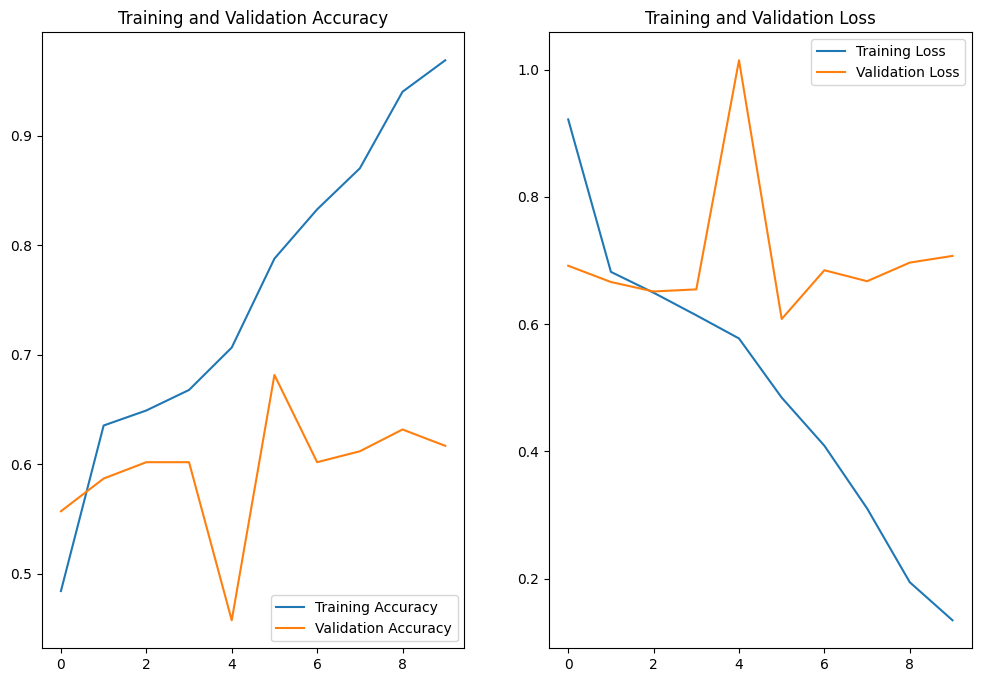

In [17]:
# Plot training & validation accuracy and loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

In [30]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.6191 - loss: 0.6774
Test loss: 0.7071793675422668
Test accuracy: 0.6169154047966003


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step


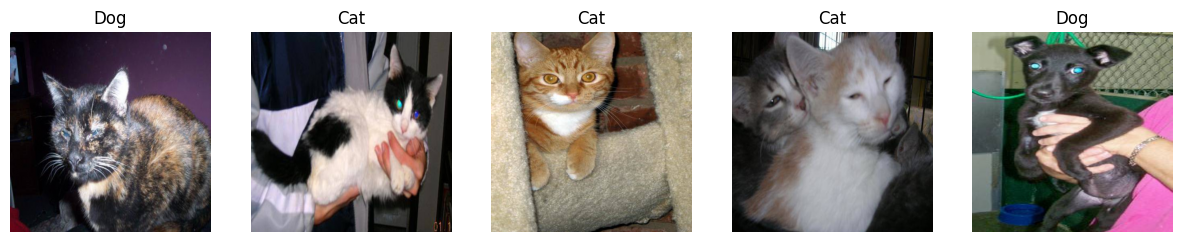

Predictions for any 10 random test images:
Image 1: Dog
Image 2: Cat
Image 3: Cat
Image 4: Cat
Image 5: Dog
Image 6: Cat
Image 7: Dog
Image 8: Dog
Image 9: Dog
Image 10: Dog


In [35]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Make predictions
test_predictions_proba = model.predict(unseen_images_preprocessed)
test_predictions = (test_predictions_proba > 0.5).astype(int)

# Visualizing some predictions
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Adjust the number of images to show
for i, ax in enumerate(axes):
    ax.imshow(unseen_images_preprocessed[i+5])
    ax.set_title('Dog' if test_predictions[i] == 1 else 'Cat')
    ax.axis('off')
plt.show()

random_indices=random.sample(range(len(unseen_images_preprocessed)),10)

#Display random test images and predictions.
print("Predictions for any 10 random test images:")
for i,idx in enumerate(random_indices):  # Adjust based on how many predictions you want to see
    print(f"Image {i+1}: {'Dog' if test_predictions[i] == 1 else 'Cat'}")
